# Assignment 11.2 - LLMs

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf.

#### Please state both names of your group members here:
Farah Ahmed Atef Abdelhameed Hafez

## Task 11.2.1: Word Embedding Model

Build and training a small transformer embedding model on example text data. It should encode words into an embedding space where similar words are close to each other.

* Set up a small Transformer model, i.e., using `PyTorch`. **(RESULT)**
* Train the model on a small text corpus, e.g., generated yourself or from the web. **(RESULT)**
* Visualize the learned word embeddings using `t-SNE` or `PCA` in a 2D plot. **(RESULT)**

Make sure to use positional encodings in your transformer model to capture word order information.

In [104]:
import math
import torch
from torch import nn, Tensor
from torch.utils.data import dataset


#Text Corpus

In [105]:
sentences = [

    "cat eats fish",
    "cat eats meat",
    "cats eat fish",
    "cats eat meat",
    "dog eats meat",
    "dog eats bone",
    "dogs eat meat",
    "dogs eat bone",
    "bird eats seed",
    "birds eat seed",
    "cat sits on sofa",
    "cats sit on sofa",
    "dog sits on sofa",
    "dogs sit on sofa",
    "bird sits on tree",
    "birds sit on tree",
    "cat walks on ground",
    "dog walks on ground",
    "cats walk on ground",
    "dogs walk on ground",
    "bird flies in sky",
    "birds fly in sky",

]


#Tokenization

In [106]:
arrayofwords=[]
for i in sentences:
  for i in i.split():
    if i not in arrayofwords:
      arrayofwords.append(i)
mywords=sorted(arrayofwords)
vocab=len(mywords)
indexedsentences=[]
for i in sentences:
  indexedsentences.append([mywords.index(j) for j in i.split()])



#Transformer

In [107]:
max_len=5000
def initPosEncod(d_model, max_len, device):
  position = torch.arange(max_len).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
  pe = torch.zeros(1,max_len, d_model, device=device)
  pe[0, :, 0::2] = torch.sin(position * div_term)
  pe[0,:, 1::2] = torch.cos(position * div_term)
  return pe

In [108]:
class transformer(torch.nn.Module):
  def __init__(self,encoderlayer, heads, lndim, embedsize, device):
    super().__init__()
    myencoder=torch.nn.TransformerEncoderLayer(d_model=embedsize, nhead=heads, dim_feedforward=lndim, batch_first=True, norm_first=True)
    self.encoder=torch.nn.TransformerEncoder(myencoder, num_layers=encoderlayer)
    self.embed=torch.nn.Embedding(vocab, embedsize)
    self.linear=torch.nn.Linear(embedsize, vocab)
    self.embedsize=embedsize
    pe= initPosEncod(embedsize, max_len, device)
    self.register_buffer('pe', pe)
  def forward(self, x):
    x=self.embed(x)
    x= x + self.pe[:, :x.size(1), :]
    T = x.size(1)
    mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
    x = self.encoder(x, mask=mask)
    x=self.linear(x)
    return x

# Build Dataset

In [109]:
mydataset= []
for i in indexedsentences:
  mydataset.append((torch.tensor(i[:-1]), torch.tensor(i[1:])))
trainloader=torch.utils.data.DataLoader(mydataset, batch_size=1, shuffle=True)



# Train

In [110]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    for i in range(epoch):
      totalloss=0
      for batch_x, batch_y in train_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          optimizer.zero_grad()
          output = model(batch_x)
          loss = criterion(output.view(-1, vocab),  batch_y.view(-1))
          totalloss+=loss.item()
          loss.backward()
          optimizer.step()

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=transformer(encoderlayer=1, heads=2, lndim=8, embedsize=8, device=device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
criterion=torch.nn.CrossEntropyLoss()
model.to(device)
train(model, trainloader, optimizer, criterion, 1000, device)



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


#Plot embedding

In [112]:
embeddings = model.embed.weight.detach().cpu().numpy()

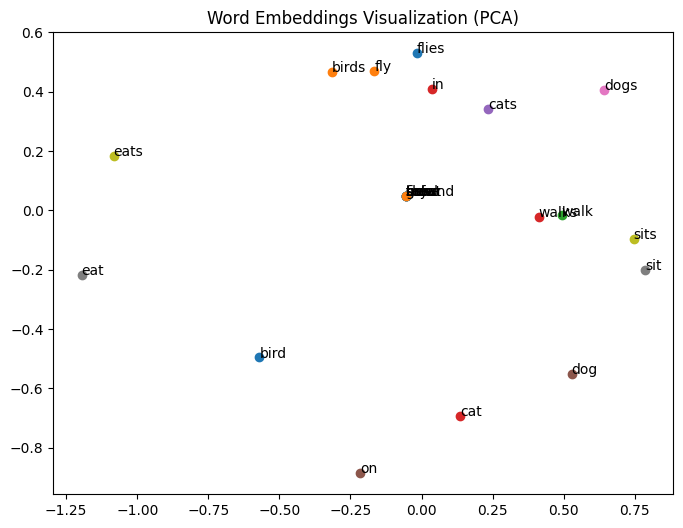

In [113]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i in range(len(mywords)):
    word = mywords[i]
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x , y , word)

plt.title("Word Embeddings Visualization (PCA)")
plt.show()


We can see that pairs of verbs (different subjects) are close together and plural pets are on one side of the grid while there singular form are on the opposite side (they are parallel just like the present and past tense verbs example in the lecture). All objects (ground, seed, etc) are clustered very closely.

## Task 11.2.2: Image Embedding Model (BONUS)

Use a pre-trained Vision Transformer (ViT) model (e.g. some suitable model from HuggingFace) to extract image embeddings from a set of images.

* Use a pre-build Vision Transformer model (whatever flavour you like :)) and train it shortly **if necessary** on CIFAR10.**(RESULT)**
* Extract CIFAR10 test image embeddings using your model. **(RESULT)**
* Visualize the extracted image embeddings using `t-SNE` or `PCA` in a 2D plot. **(RESULT)**

In [114]:
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTModel
from transformers import TrainingArguments, Trainer
from torchvision.transforms import Normalize, Resize, ToTensor, Compose, Lambda




#Load dataset

In [115]:
mydata = load_dataset("cifar10")
#train=mydata["train"]
test=mydata["test"]



#Load model and prepare dataset

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224"
model = ViTModel.from_pretrained(model_name)
model.to(device)
processor = ViTImageProcessor.from_pretrained(model_name)

transf = Compose([
    Resize(processor.size['height']),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

def tansform_image(arg):
  arg["pixel_values"]=[]
  for img in arg['img']:
    arg["pixel_values"].append(transf(img.convert('RGB')))
  return arg

# train.set_transform(tansform_image)
test.set_transform(tansform_image)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Extract embeddings of subset of test images

In [117]:
model.eval()
embeddings = []
labels=[]
with torch.no_grad():
  for i in range(100):
    img= test[i]
    labels.append(img["label"])
    pixel_values = img["pixel_values"].unsqueeze(0).to(device)
    outputs = model(pixel_values)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    embeddings.append(cls_embedding.cpu().numpy()[0])

#Plot

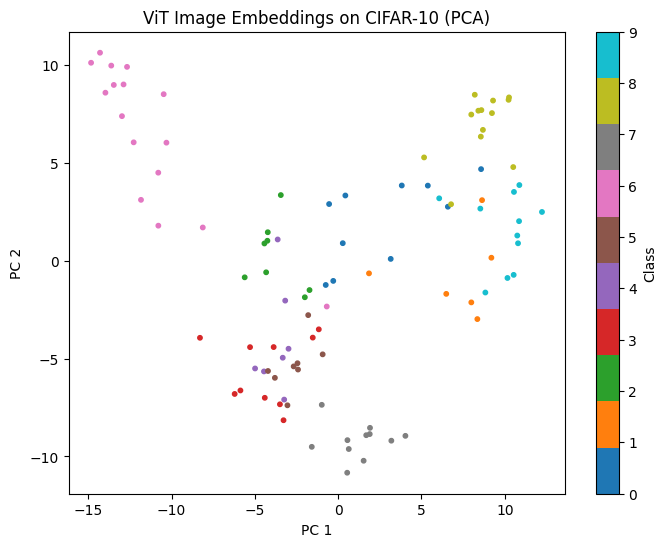

In [118]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    s=10,
    cmap="tab10"
)
plt.title("ViT Image Embeddings on CIFAR-10 (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Class")
plt.show()

We can see that images of same classes are clustered close to each other. One thing to recognise is that there might be some classes overlapping, yet PCA can hide quality because of compression (removing non-linear structure), so we can say that if it looks this good in PCA, embeddings are assumed to be very good in the full dimension, so extra training is not necessary.

## Congratz, you made it! :)